<a href="https://colab.research.google.com/github/sulabh007/oral_cancer_detection_DAI/blob/main/custom%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import re
import random
import matplotlib.pyplot as plt

In [137]:
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from pandas import DataFrame
from typing import Tuple, Dict, List
from torch.utils.data import Dataset, DataLoader

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BUFFER = 0
NUM_WORKER=0
RANDOM_SEED = 23

In [107]:
# Setup path to data folder
drive_path = Path('/content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data')


# Setup path to train and test dataset
patch_dir = drive_path / 'patch'
train_test_dir = patch_dir / 'images'

# Setup path for target directory
eval_directory = drive_path / 'images'


In [108]:
print("Data Directory: ", drive)
print(f"Train and Test directory: {train_test_dir}")
print(f"Evaluation directory: {eval_directory}")

Data Directory:  <module 'google.colab.drive' from '/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'>
Train and Test directory: /content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/patch/images
Evaluation directory: /content/drive/MyDrive/NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data/images


In [148]:
# Setup Path of training dataset images and class label
train_ds = pd.read_csv(patch_dir/"sabpatch_parsed_folders.csv", usecols=['path','lesion'])
train_ds.head()

,path,lesion
0,p0000.png,OSCC
1,p0001.png,OSCC
2,p0002.png,OSCC
3,p0003.png,OSCC
4,p0004.png,OSCC


In [110]:
train_ds['lesion'].value_counts()

With dysplasia       1608
OSCC                  939
Without dysplasia     589
Name: lesion, dtype: int64

In [149]:
# Setup Path of testing dataset images and class label
test_ds = pd.read_csv(patch_dir/"sabpatch_parsed_test.csv", usecols=['path','lesion'])
test_ds.head()

,path,lesion
0,p3136.png,OSCC
1,p3137.png,OSCC
2,p3138.png,OSCC
3,p3139.png,OSCC
4,p3140.png,OSCC


In [112]:
test_ds['lesion'].value_counts()

With dysplasia       322
OSCC                 187
Without dysplasia    118
Name: lesion, dtype: int64

In [150]:
# Setup path for Evaluation images and class label
eval_ds = pd.read_csv(drive_path/'ndb-ufes.csv', usecols=['path','diagnosis'])
eval_ds.head()

,path,diagnosis
0,0000.png,OSCC
1,0001.png,OSCC
2,0002.png,OSCC
3,0003.png,OSCC
4,0004.png,OSCC


In [114]:
eval_ds['diagnosis'].value_counts()

OSCC                             91
Leukoplakia with dysplasia       89
Leukoplakia without dysplasia    57
Name: diagnosis, dtype: int64

In [115]:
## As observed Eval label and Train-Test label are different
## we use this function to make it same

def remove_substr(text: str) -> str:
    return re.sub('Leukoplakia ', '', text)

In [116]:
eval_ds['diagnosis'] = eval_ds['diagnosis'].apply(remove_substr)

<ipython-input-116-b8414ce114c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_ds['diagnosis'] = eval_ds['diagnosis'].apply(remove_substr)


In [129]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
class ImageFolderCustom(Dataset):

    # 1. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, path_df: DataFrame, transform=None) -> None:

        # Get all image paths, classes
        self.img_df = path_df

        # Set all images to proper path
        self.img_df['path'] = self.check_path(targ_dir)

        self.paths = list(self.img_df['path'])

        # Setup transforms
        self.transform = transform

        self.classes, self.class_to_idx = self.find_classes()

    # 2. check if its already in proper format
    def check_path(self, targ_dir: str) -> DataFrame:
        if str(targ_dir) in self.img_df.iloc[0,0]:
            return self.img_df['path'].astype('string')
        else:
            return str(targ_dir)+ '/' +  self.img_df['path'].astype('string')

    # 3. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_df.iloc[index, 0]
        return Image.open(image_path)

    # 4. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return self.img_df.shape[0]

    # 5. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.img_df.iloc[index, 1] # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


    def find_classes(self) -> Tuple[List[str], Dict[str, int]]:

        col = self.img_df.columns
        # 1. Get the class names by scanning the target directory
        classes = sorted(self.img_df[col[1]].unique())

        # 2. Raise an error if class names not found
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes.")

        # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [130]:
train_transforms = transforms.Compose([
    #transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    #transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [131]:
train_data = ImageFolderCustom(targ_dir = train_test_dir,
                                      path_df = train_ds,
                                      transform= train_transforms)

test_data = ImageFolderCustom(targ_dir = train_test_dir,
                                      path_df = test_ds,
                                      transform= test_transforms)

<ipython-input-129-db13d8bc5dd0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.img_df['path'] = self.check_path(targ_dir)


In [132]:
eval_data = ImageFolderCustom(targ_dir = eval_directory,
                                      path_df = eval_ds,
                                      transform= test_transforms)


<ipython-input-129-db13d8bc5dd0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.img_df['path'] = self.check_path(targ_dir)


In [147]:
classes, class_to_idx = train_data.find_classes()    #Label

print("Class label for training\n")
classes, class_to_idx

Class label for training



(['OSCC', 'With dysplasia', 'Without dysplasia'],
 {'OSCC': 0, 'With dysplasia': 1, 'Without dysplasia': 2})

In [125]:
print("Train Data Size: ", len(train_data))
print("Test Data Size: ", len(test_data))
print("Evalution Data Size: ", len(eval_data))

Train Data Size:  3136
Test Data Size:  627
Evalution Data Size:  237


In [126]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"{classes[targ_label]}"
            if display_shape:
                title = title + f"\n{targ_image_adjust.shape}"
        plt.title(title)

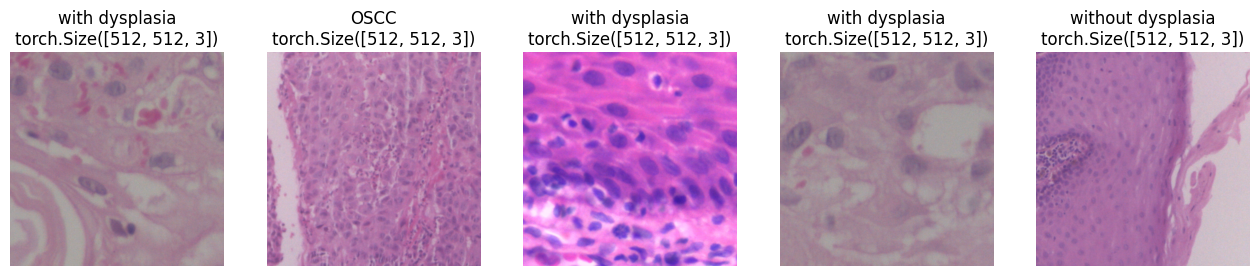

In [127]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=classes,
                      seed=None)


In [141]:
# Turn train, test and eval Dataset's into DataLoader's

train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

eval_dataloader = DataLoader(dataset=eval_data, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data


train_dataloader, test_dataloader, eval_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f39fc4a8fa0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f39fc4ab6d0>)

In [142]:
# Get image and label from custom DataLoader
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 512, 512]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])
